### Step 1: Importing the dependencies

In [36]:
import pandas as pd
import re
import pickle
import tensorflow as tf
import tensorflow_text as text
import tensorflow_datasets as tfds
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from tensorflow.keras.layers import TextVectorization
import string

# Download NLTK resources (stopwords and WordNet)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/yuvraj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yuvraj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Defining Parameters

In [2]:
# Shuffle and batch the dataset
batch_size = 32
seed = 42

# Vocabulary size and number of words in a sequence
vocab_size = 10000
sequence_length = 100

stop_words = tf.constant(stopwords.words('english'))

### Step 2: Creation of Questions dataframe
Currently there are 5 different files belonging to 5 different domain of the questions and in this module we will be creating a dataframe that will be having total of 1600 questions belonging to 5 different domains. The domains are 
- DSA questions
- System design questions
- AI questions
- Computer fundamental questions
- Behavioural questions

In [3]:
file_paths = ['../Dataset/DSA_que.txt', '../Dataset/System_Design_que.txt', '../Dataset/Behavioural_que.txt',
              '../Dataset/CS_fundamentals.txt', '../Dataset/AI_que.txt']
que_type = {0: 'DSA',
            1: 'System_design',
            2: 'Behavioural',
            3: 'CS_fundamentals',
            4: 'AI'}
count = 0
df = pd.DataFrame()

# Going over all the paths
for paths in file_paths:
    try:
        # Reset que_ls for each file iteration
        que_ls = []

        with open(paths, 'r') as file:
            lines = file.readlines()
            for line in lines:
                
                # Removing the leading and following white space after reading content from the file
                line = line.strip()
                
                # Saving the line in the que list
                que_ls.append(line)

            # Creating series from the 
            que_sr = pd.Series(que_ls)
            temp_df = pd.DataFrame({'Que': que_sr})

            # Adding a feature 'Category'
            temp_df['Category'] = que_type[count]
            count = count + 1

            # Concatenating the dataframes
            df = pd.concat([df, temp_df], axis=0)

    except FileNotFoundError:
        print(f"The file {paths} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [4]:
# Shuffling the dataframe
df = df.sample(frac=1, random_state=42)

# Resetting the index
df.reset_index(drop=True,inplace=True)

In [5]:
# Saving the dataframe
# df.to_csv('../Dataset/Que_Classification.csv')

### Exploratory data analysis
In this module our aim will be derive some useful insights from the questions belonging to differet domains and this analysis will further help us to decide what type of feature engineering we will do.

In [52]:
# Checking any 5 random rows from the dataframe
df.sample(5)

,Que,Category
1402,Explain the concept of attention mechanisms in...,AI
111,Differentiate between a skip list and a doubly...,DSA
293,Share a story about a time when you successful...,Behavioural
710,Design a scalable and efficient search engine.,System_design
1420,What is the purpose of a double-ended priority...,DSA


In [63]:
df['Category'].value_counts().index

Index(['AI', 'CS_fundamentals', 'System_design', 'DSA', 'Behavioural'], dtype='object', name='Category')

In [53]:
# Checking percentage of missinng values
df.isnull().mean()*100

Que         0.0
Category    0.0
dtype: float64

In [62]:
# Checking if there are any duplicate values
duplicate_counts = df.duplicated().sum()
if duplicate_counts > 0:

    # Storing all the duplicate data
    Duplicate_df = df[df.duplicated() == True]
    print("Duplicate values found and stored in dataframe, dataframe size : ",Duplicate_df.shape[0])
else:
    print("There are no duplicate values")

Duplicate values found and stored in dataframe, dataframe size :  430


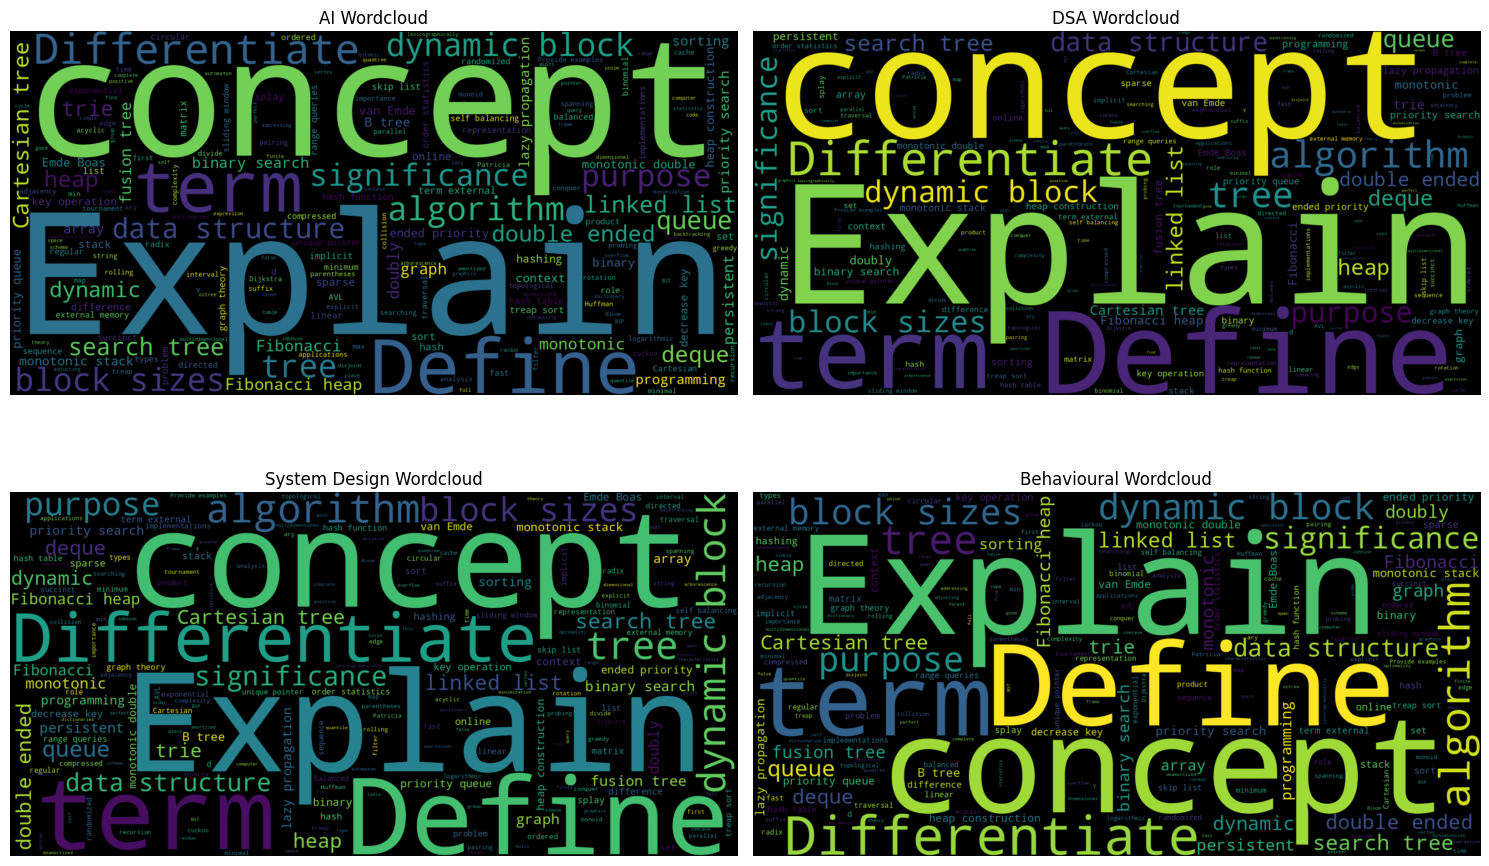

In [46]:
# Extracting the course titles and joining sentences into a single string
ai_que = df[df['Category'] == 'AI']['Que'].values
dsa_que = df[df['Category'] == 'DSA']['Que'].values
sd_que = df[df['Category'] == 'System_design']['Que'].values
beh_que = df[df['Category'] == 'Behavioural']['Que'].values

# Extracting all the questions into single string
ai_que_string = " ".join(dsa_que.tolist())  
dsa_que_string = " ".join(dsa_que.tolist())  
sd_que_string = " ".join(dsa_que.tolist())  
beh_que_string = " ".join(dsa_que.tolist())  

# Set other parameters
wordcloud1 = WordCloud(width=1600, height=800).generate(ai_que_string)
wordcloud2 = WordCloud(width=1600, height=800).generate(dsa_que_string)
wordcloud3 = WordCloud(width=1600, height=800).generate(sd_que_string)
wordcloud4 = WordCloud(width=1600, height=800).generate(beh_que_string)

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].imshow(wordcloud1, interpolation='bilinear')
ax[0, 0].set_title('AI Wordcloud')
ax[0, 0].axis('off')

ax[0, 1].imshow(wordcloud2, interpolation='bilinear')
ax[0, 1].set_title('DSA Wordcloud')
ax[0, 1].axis('off')

ax[1, 0].imshow(wordcloud3, interpolation='bilinear')
ax[1, 0].set_title('System Design Wordcloud')
ax[1, 0].axis('off')

ax[1, 1].imshow(wordcloud4, interpolation='bilinear')
ax[1, 1].set_title('Behavioural Wordcloud')
ax[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [42]:
# Extracting the course titles and joining sentences into a single string
dsa_que = df[df['Category'] == 'System_design']['Que'].values
dsa_que_string = " ".join(dsa_que.tolist())  

# Set other parameters
wordcloud1 = WordCloud(width=1600, height=800).generate(dsa_que_string)

plt.figure( figsize=(15,5), facecolor='k')
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.savefig('wordcloud.png', facecolor='k')

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

(-0.5, 1599.5, 799.5, -0.5)

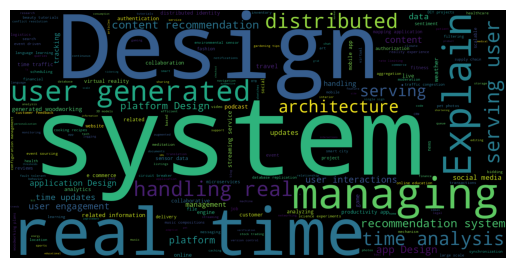

In [43]:
plt.imshow(wordcloud1)
plt.axis("off")

### Loading data to tensorflow dataset
Loading data into tf.data.Dataset offers several advantages and reasons why it's commonly used in TensorFlow pipelines:

- Efficient Memory Usage: TensorFlow dataset API provides efficient handling of large datasets by streaming data from disk or memory. It loads data on-the-fly, which is particularly useful when dealing with datasets that do not fit entirely into memory.

- Parallelism: TensorFlow's data API supports parallel data loading and preprocessing. This enables faster data pipeline execution, especially on multi-core CPUs or GPUs, as data loading and preprocessing can be performed in parallel with model training or inference.

- Data Transformation: tf.data.Dataset allows for easy and flexible data transformation and preprocessing. You can apply various transformations such as shuffling, batching, mapping, filtering, and more to the dataset to prepare it for training or inference.

In [6]:
# Creating TensorFlow Dataset directly from the DataFrame
raw_text_ds = tf.data.Dataset.from_tensor_slices((df['Que'],df['Category']))

# SHuffling the items and creating batches
raw_text_ds = raw_text_ds.shuffle(len(df), seed=seed).batch(batch_size)

In [7]:
# Display some benchmark statistics
tfds.benchmark(raw_text_ds)


************ Summary ************



  0%|          | 0/52 [00:00<?, ?it/s]

Examples/sec (First included) 926.20 ex/sec (total: 53 ex, 0.06 sec)
Examples/sec (First only) 25.09 ex/sec (total: 1 ex, 0.04 sec)
Examples/sec (First excluded) 2993.18 ex/sec (total: 52 ex, 0.02 sec)


,duration,num_examples,avg
first+lasts,0.057223,53,926.204273
first,0.039850,1,25.094106
lasts,0.017373,52,2993.184232


In [8]:
print("TEXT")
for text_batch,label_batch in raw_text_ds.take(1):
  for i in range(5):
    print(text_batch.numpy()[i])

print("LABELS")
for text_batch,label_batch in raw_text_ds.take(1):
  for i in range(5):
    print(label_batch.numpy()[i])

TEXT
b'What is the purpose of the I/O scheduler in an operating system?'
b'Describe a situation where you had to collaborate with other departments to enhance customer experience.'
b'What is the difference between breadth-first search (BFS) and depth-first search (DFS)?'
b'How would you design an e-commerce checkout system?'
b'Discuss the role of activation functions in preventing vanishing gradients.'
LABELS
b'DSA'
b'System_design'
b'AI'
b'System_design'
b'AI'


### Train, test split + Data loading optimization

In [10]:
print("Total Batches : ",len(raw_text_ds))
print("Total Training Batches (80:20) : ",len(raw_text_ds)*0.8)
print("Total Testing Batches : ",len(raw_text_ds)*0.2)

Total Batches :  52
Total Training Batches (80:20) :  41.6
Total Testing Batches :  10.4


The performance of a dataset pipeline can have a significant impact on the performance of a machine learning model. If a dataset pipeline is slow, it can bottleneck the overall performance of the model. tfds.benchmark is a simple and easy-to-use tool for evaluating the performance of dataset pipelines. It can be used to identify bottlenecks, compare different pipelines, and track progress over time.

In [11]:
def create_train_test_val(ds,train_size,val_size):
    
    # Calculating total batches
    total_batches = len(ds)
    
    # Extracting training,testing and validation batch from the dataset (ds)
    train_ds_batches = int(train_size*total_batches)
    test_ds_batches = int(val_size*total_batches)
    
    # 80:20
    train_ds = ds.take(train_ds_batches) 
    test_ds = ds.skip(train_ds_batches).take(test_ds_batches)
    
    # Catching and prefetching the dataset to improve data pipeline performance
    train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_ds,test_ds


# Calling the function
train_ds,test_ds = create_train_test_val(raw_text_ds,0.8,0.2)

In [12]:
# Display some benchmark statistics
tfds.benchmark(train_ds)


************ Summary ************



  0%|          | 0/41 [00:00<?, ?it/s]

Examples/sec (First included) 969.78 ex/sec (total: 42 ex, 0.04 sec)
Examples/sec (First only) 33.82 ex/sec (total: 1 ex, 0.03 sec)
Examples/sec (First excluded) 2984.58 ex/sec (total: 41 ex, 0.01 sec)


,duration,num_examples,avg
first+lasts,0.043309,42,969.784068
first,0.029571,1,33.816531
lasts,0.013737,41,2984.580492


In [21]:
len(train_ds)

41

### Data processing pipeline

Operations within TensorFlow preprocessing layers like TextVectorization get compiled into a static graph for performance optimizations. Thus Libraries like WordNetLemmatizer aren't designed for this graph context and might not operate correctly within it.

In [12]:
# Example to understand why we need to do lowercasing
word1 = "cat"
word2 = "Cat"
word2_lowercased = word2.lower()

def compare(word1,word2):
    if word1 == word2:
        print("Same")
    else:
        print("Differnt")

compare(word1,word2)
compare(word1,word2_lowercased)

Differnt
Same


In [31]:
# Function to process a single text entry in the dataset
def process_text(text):
    """
    Input : Single raw text
    Output: Cleaned text

    Description: This function will take a single raw text as input, remove all stopwords and punctuation, then lowercase the words to eliminate any ambiguity. 
    Ultimately, lemmatization will be applied to the text, and clean text will be returned.
    """
    # Lowercasing and Tokenizing the text
    tokens = tf.strings.lower(tf.strings.split(text))
    
    # Removing the stopwords as they don't provide any information
    tokens = tf.where(~tf.equal(tokens, stop_words))[:, 1]
    
    # Convert integer tokens to strings as tf.where return integer indices
    tokens = tf.strings.as_string(tokens)
    
    # Removing punctuation
    tokens = tf.strings.regex_replace(tokens, '[%s]' % re.escape(string.punctuation), '')
    
    # Lemmatization using TensorFlow Text
    lemmatizer = text.WhitespaceTokenizer().lemmatize
    tokens = lemmatizer(tokens)
    
    # Join tokens back into a single string
    processed_text = tf.strings.reduce_join(tokens, separator=' ')
    
    return processed_text

In [28]:
import tensorflow as tf
import tensorflow_text as text

lemmatizer = tf.text.Lemmatizer()
lemmas = lemmatizer.lemmatize(["went", "running", "better"])
print(lemmas.numpy())  # Output: [b'go' b'run' b'good']


AttributeError: module 'tensorflow' has no attribute 'text'

In [16]:
str = "The quick brown fox jumps over the lazy dogs, but they don't seem to care about it."
output = process_text(str)
print(output.numpy())

b'quick brown fox jump lazy dog seem care it'


### Quick Note: Why to use tf.py_function with custom python functions ?
The tf.py_function is used in this context to incorporate a Python function (process_text in this case) into a TensorFlow computational graph. TensorFlow operations are typically written in TensorFlow's native language (graph operations) for better performance, but sometimes you need to use external Python code that TensorFlow doesn't know how to execute directly. tf.py_function serves as a bridge to allow you to use regular Python functions within the TensorFlow graph.

Here's why you need tf.py_function in the process_dataset_element:

- Integration with TensorFlow Graph: TensorFlow operates with a computational graph, and many of its operations are written in C++ or CUDA for efficiency. The tf.py_function allows you to include your custom Python code (process_text) within this graph, ensuring that the entire data processing pipeline can be efficiently executed.

- Eager Execution Compatibility: If you're working in TensorFlow 2.0 or later with eager execution enabled, you might wonder why you need tf.py_function. While eager execution is more Pythonic and allows you to use regular Python functions directly, using tf.py_function ensures that the same code can be seamlessly switched to graph mode for performance gains during model training.

- Parallel Execution and Distributed Training: TensorFlow can parallelize the execution of operations, and tf.py_function allows TensorFlow to handle parallel execution efficiently. This is particularly important when dealing with large datasets or when training models on distributed systems.

- Consistency in Tensor Shapes: When using tf.py_function, TensorFlow is better able to manage and infer the shapes of the tensors involved, ensuring compatibility with the rest of your graph.

In summary, tf.py_function is a wrapper that allows you to use your custom Python functions within the TensorFlow graph, ensuring compatibility with TensorFlow's computation engine. While it introduces a slight overhead due to the transition between Python and TensorFlow execution, it is a necessary step to incorporate non-TensorFlow code seamlessly into the TensorFlow pipeline. If you are using TensorFlow 2.0 or later, you can experiment without tf.py_function and rely on eager execution, but keep in mind the potential performance implications, especially during large-scale training scenarios.

In [24]:
# Defining the text vectorization layer
vectorize_layer = TextVectorization(
    standardize=process_text,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Making a text-only dataset ( with no labels) and calling adapt to build the vocabulary.
train_text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text_ds)

AttributeError: in user code:

    File "/home/yuvraj/miniconda3/lib/python3.11/site-packages/keras/src/engine/base_preprocessing_layer.py", line 123, in adapt_step  *
        self.update_state(data)
    File "/home/yuvraj/miniconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/text_vectorization.py", line 476, in update_state  **
        self._lookup_layer.update_state(self._preprocess(data))
    File "/home/yuvraj/miniconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/text_vectorization.py", line 579, in _preprocess
        inputs = self._standardize(inputs)
    File "/tmp/ipykernel_24784/1801945490.py", line 15, in process_text
        tokens = [token for token in tokens if token.numpy().decode('utf-8') not in stop_words]
    File "/tmp/ipykernel_24784/1801945490.py", line 15, in <listcomp>
        tokens = [token for token in tokens if token.numpy().decode('utf-8') not in stop_words]

    AttributeError: 'Tensor' object has no attribute 'numpy'


### Embedding layer in TensorFlow:

In TensorFlow, the tf.keras.layers.Embedding layer serves as a powerful tool for converting discrete integer word indices into dense, low-dimensional vector representations. These vectors capture semantic relationships between words, making them highly valuable for tasks like sentiment analysis, topic modeling, and machine translation.

**Key Characteristics**:

- Discrete Integer Input: The layer requires input in the form of positive integers, where each integer represents a unique word in your vocabulary.
- Vector Lookup: At its core, the embedding layer acts as a giant lookup table. For each integer input, it retrieves the corresponding pre-trained embedding vector from a massive matrix.
- Learnable Parameters: This embedding matrix holds the essential parameters that are learned during model training. As your model trains, these vectors automatically evolve to better represent word meanings and relationships within the context of your specific task.

**Pretrained or Learned Embeddings?**

TensorFlow's Embedding layer offers flexibility in how you create these vector representations:

- Pretrained Embeddings: You can leverage pre-trained embeddings from sources like Word2Vec, GloVe, or FastText. These embeddings are trained on large text corpora and often capture valuable semantic information. By loading them directly into your Embedding layer, you benefit from the knowledge encoded in these pre-trained vectors.
- Learned Embeddings: Alternatively, you can start with random values for the embedding matrix and let your model learn them dynamically during training. This approach is suitable for smaller datasets or if you want the embeddings to be specifically tailored to your task and domain.

**Choosing the Right Approach**: The choice between using pre-trained embeddings or learning them from scratch depends on several factors:

- Dataset Size: If you have a large dataset, pre-trained embeddings often provide a good starting point and can expedite training. For smaller datasets, learning embeddings from scratch might be necessary.
- Task Specificity: For tasks with specific domain knowledge, learning embeddings from scratch can potentially capture those nuances better.
    Computational Resources: Training large embedding matrices from scratch can be computationally expensive. Using pre-trained embeddings can alleviate this burden.

**Key Considerations**:

- Vocabulary Size: The embedding matrix dimension (number of vectors) is typically equal to the vocabulary size, so larger vocabularies lead to larger matrices and higher computational costs.
- Embedding Dimensionality: The dimensionality of each embedding vector determines the level of detail it can capture. Experimenting with different dimensions is often helpful to find a balance between information richness and model complexity.
- Non-static Embeddings: While TensorFlow's Embedding layer typically uses static (fixed) representations, newer approaches like word embeddings from contextual language models (e.g., BERT) provide context-aware representations that can further enhance performance.

b'quick brown fox jump lazy dog seem care it'
